# Atividade: Dense Neural Network Breast Cancer
**INSTITUTO FEDERAL DE MINAS GERIAS**
*Departamento de Engenharia e Computação*

**Professor:** Ciniro Nametala

**Aluno:** Euler Gomes

Neste trabalho, vamos utilizar o dataset Breast Cancer Wisconsin (Diagnostic) disponível no repositório de datasets da UCI. Este é um conjunto de dados multivariado com atributos numéricos de ponto-flutuante usado para classificação do tipo de cancêr de mama de um paciente com MALIGNO ou BENIGNO. O dataset mostra resultados de exames de 699 pacientes coletados em

1. ID do paciente
2. Espessura (1-10)
3. Uniformidade de tamanho da célula (1-10)
4. Uniformidade de forma da célula (1-10)
5. Adesão marginal (1-10)
6. Tamanho único epitelial da célula (1-10)
7. Quantidade de núcleos nus (1-10)
8. Cromatina (1-10)
9. Quantidade de núcleos normais (1-10)
10. Mitoses (1-10)
[SAIDA] 11. Classificação (2 para indicar BENIGNO, 4 para inicar MALIGNO)

O dataset contém 458 amostras com:
- 65.5% de casos BENIGNOS
- 34.5% de casos MALIGNOS

In [9]:
#funcao para deixar o Jupyter com celular preenchendo a tela toda
from IPython.display import display, HTML

display(HTML("<style>.container {widht: 100% !important;}</style>"))

In [10]:
#importacao de bibliotecas
import subprocess
import sys

#bibliotecas para trabalhar com dados e graficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

#bibliotecas do scikit-learn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#biblioteca para exportacoes e importacoes de arquivos
from joblib import dump, load

#utilitario de GPU
from numba import cuda

#biblioteca para implementar uma barra de progresso
import progressbar

#biblioteca para tocar sons
import pygame

#bibliotecas para deep learning
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LayerNormalization, BatchNormalization, Flatten, Dense, Reshape, Dropout

from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import BinaryCrossentropy

#bibliotecas para plotar graficos do keras
import pydot as pyd
import pydotplus
from pydotplus import graphviz
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd


In [11]:
#checagem de gpu
import tensorflow as tf
import keras
print('TensorFlow:', tf.__version__)
print('Keras:', keras.__version__)
print('GPU disponivel:', len(tf.config.list_physical_devices('GPU')))

TensorFlow: 2.20.0
Keras: 3.12.0
GPU disponivel: 0


2025-11-14 10:40:15.757116: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [12]:
#rotina para exportacao da lista de pacotes
def exportaRequirements():
    try:
        resultado = subprocess.run([sys.executable, "-m", "pip", "freeze"],
                                   capture_output=True,
                                   text=True,
                                   check=True)
        with open('requirements.txt', 'w') as f:
            f.write(resultado.stdout)
        print('Arquivo requirements.txt gerado com sucesso')
    except subprocess.CalledProcessError as e:
        print('Erro ao gerar arquivo requirements.txt:', e)

exportaRequirements()

Arquivo requirements.txt gerado com sucesso


## 2. Importação do dataset

In [13]:
#2 benigno 4 maligno
col_names = ['ID', 'espessura', 'tam_celula', 'forma_celula', 'adesao', 'tam_epitelial','nucleos_nus', 'cromatina', 'nucleos_normais', 'mitoses', 'diagnostico']
#importacao do dataset
data = pd.read_csv('dataset/dataset_breastcancer.csv', header=None, names=col_names)
#remove a coluna ID do dataset
data = data.drop(columns=['ID'], axis=1)

#substitui interrogação por NaN
data = data.replace('?', np.nan)

#converte tudo para numero
data = data.astype(float)

#converte o codigo do diagnostico para 0 e 1
data = data.assign(diagnostico=data['diagnostico'].replace({2:0, 4:1}))

#nomeia as estradas e saidas
x_names = data.columns[:-1].tolist()
y_names = data.columns[-1:].tolist()

data.head()


,espessura,tam_celula,forma_celula,adesao,tam_epitelial,nucleos_nus,cromatina,nucleos_normais,mitoses,diagnostico
0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0
1,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,0.0
2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,0.0
3,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,0.0
4,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,0.0


## 3. Configuração do Experimento

In [14]:
#realizar interpolacao de dados
interp_exec = True

#realizar deteccao e substituicao de outliers
outliers_exec = True

#realizar normalizacao de dados
normalization_exec = True

#realizar escalonamento de dados
scale_exec = True

#exportar os datasets tratados
export_frames = True

#gerar um novo modelo ou usar um pronto
new_model = True

## 4. Análise de Dados

Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/home/euler/anaconda3/envs/tf/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/euler/anaconda3/envs/tf/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 2.335
findfont: score(FontEntry(fname='/home/euler/anaconda3/envs/tf/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
f

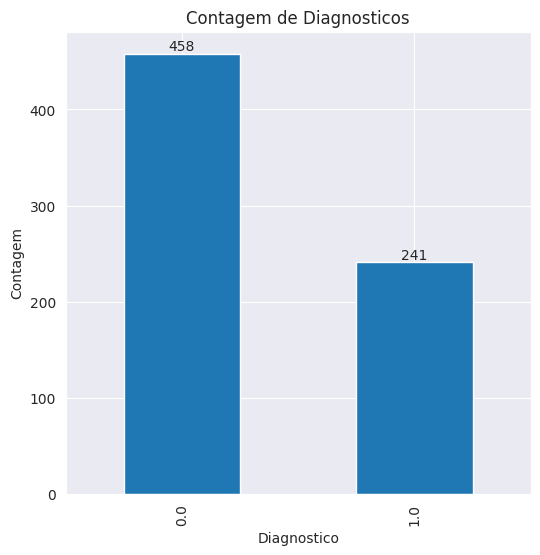

In [15]:
#contagem de diagnosticos
diag_counts = data['diagnostico'].value_counts()

#plota grafico de barra
plt.figure(figsize = (6,6))
diag_counts.plot(kind="bar")
plt.xlabel("Diagnostico")
plt.ylabel('Contagem')
plt.title('Contagem de Diagnosticos')

#adiciona os rotulos
for i, count in enumerate(diag_counts):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=10)

plt.show()

## 4.1. Sumarização estatística

In [22]:
def sumarizacao(data):
    stats = []

    for column in x_names:
        values = data[column]

        maximum = round(values.max(), 2)
        minimum = round(values.min(), 2)
        mean = round(values.mean(),2)
        median = round(values.median(),2)
        std = round(values.std(), 2)

        stats.append([column, maximum, minimum, mean, median, std])

    headers = ['Coluna', 'Máximo', 'Minimo', 'Média', 'Mediana', 'Desvio Padrão']

    table = tabulate(stats,headers, tablefmt="pipe")
    print(table)

sumarizacao(data)

| Coluna          |   Máximo |   Minimo |   Média |   Mediana |   Desvio Padrão |
|:----------------|---------:|---------:|--------:|----------:|----------------:|
| espessura       |       10 |        1 |    4.42 |         4 |            2.82 |
| tam_celula      |       10 |        1 |    3.13 |         1 |            3.05 |
| forma_celula    |       10 |        1 |    3.21 |         1 |            2.97 |
| adesao          |       10 |        1 |    2.81 |         1 |            2.86 |
| tam_epitelial   |       10 |        1 |    3.22 |         2 |            2.21 |
| nucleos_nus     |       10 |        1 |    3.54 |         1 |            3.64 |
| cromatina       |       10 |        1 |    3.44 |         3 |            2.44 |
| nucleos_normais |       10 |        1 |    2.87 |         1 |            3.05 |
| mitoses         |       10 |        1 |    1.59 |         1 |            1.72 |


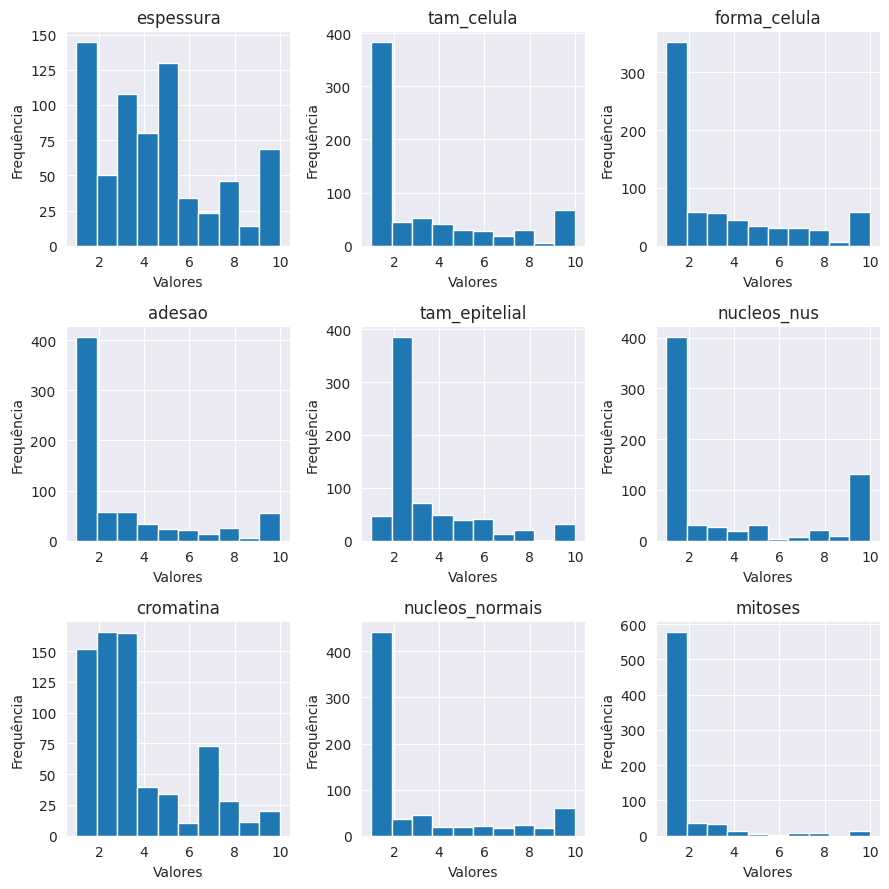

In [23]:
fig, axs = plt.subplots(3,3, figsize=(9,9), tight_layout=True)

for i, column in enumerate(x_names):
    row = i // 3 #linha atual
    col = i % 3 #coluna atual

    axs[row, col].hist(data[column], bins=10)
    axs[row, col].set_title(column)
    axs[row, col].set_xlabel('Valores')
    axs[row, col].set_ylabel('Frequência')


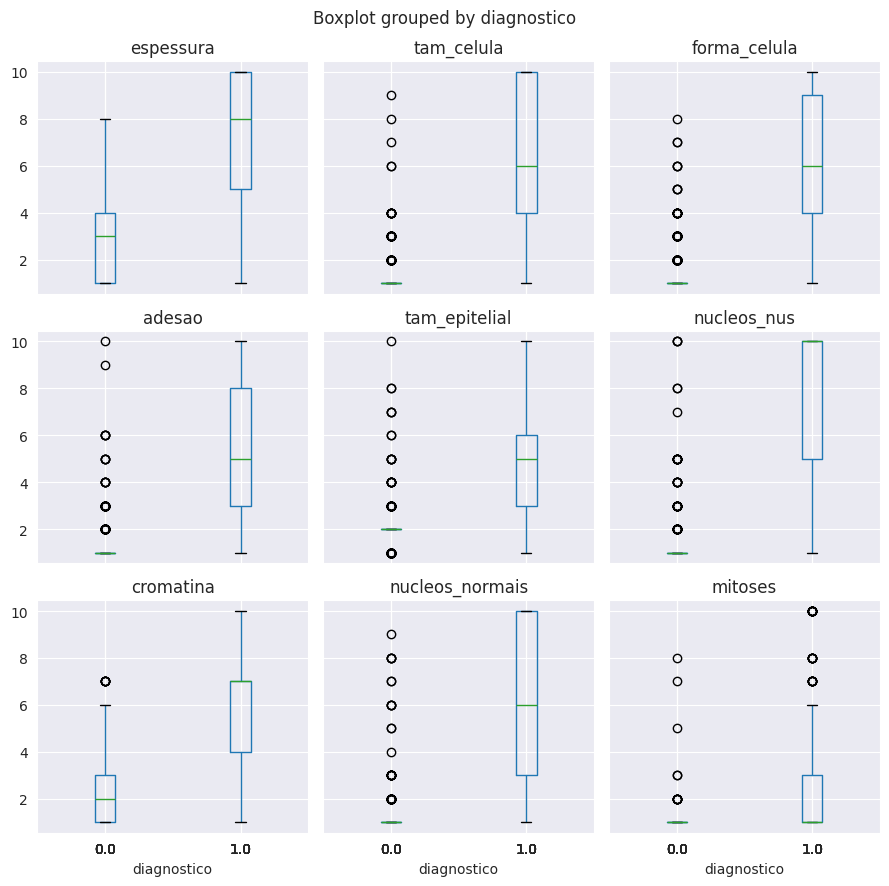

In [30]:
data.boxplot(column = x_names, by = 'diagnostico',figsize=(9,9))
plt.tight_layout()
plt.show()